In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvidia-smi # Tesla T4 GPU is removed from colab free tier

Wed Dec  1 08:58:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    31W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib

In [ ]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13426371132832079124
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7638343534199312275
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Activation,Dropout,Input,LeakyReLU,Conv2DTranspose,Concatenate,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils.vis_utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
from matplotlib.image import imread
import os
import time
from tensorflow import keras
tf.config.run_functions_eagerly(True)

In [ ]:
# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 120

# These many images will be used from the data archive
dataset_split = 500

In [ ]:
#img_size = 480

In [ ]:
os.listdir()

['.config', 'drive', 'data', '.ipynb_checkpoints', 'sample_data']

## **We are using Unsplash free to use dataset for this experimental project**

In [ ]:
master_dir = 'data'

In [ ]:
X = []
y = []

In [ ]:
os.listdir( master_dir )

In [ ]:
my_img = '419.jpg'

In [ ]:
rgb_image = Image.open( os.path.join( master_dir , my_img ) ).resize( ( img_size , img_size ) )

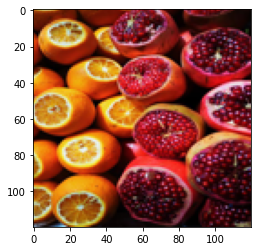

In [ ]:
plt.imshow(rgb_image)

In [ ]:
os.listdir( master_dir )

In [ ]:
rmdir /content/data/.ipynb_checkpoints

In [ ]:
for image_file in os.listdir( master_dir ):
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) ) 
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
    # Append both the image arrays
    X.append( gray_img_array )
    y.append( rgb_img_array )

# Train-test splitting
train_X, test_X, train_y, test_y = train_test_split( np.array(X) , np.array(y) , test_size=0.2 )

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( train_X , train_y ) )
dataset = dataset.batch( batch_size )

## **Generator**

In [ ]:
def generator_model():
  input_img = Input(shape=(img_size,img_size,1))

  conv1 = Conv2D(16,kernel_size=(5,5),strides=1)(input_img)
  conv1 = LeakyReLU () ( conv1 )
  conv1 = Conv2D(32,kernel_size=(3,3),strides=1)(conv1)
  conv1= LeakyReLU()(conv1)
  conv1 = Conv2D(32,kernel_size=(3,3),strides=1)(conv1)
  conv1= LeakyReLU()(conv1)


  conv2 = Conv2D(32,kernel_size=(5,5),strides=1)(conv1)
  conv2= LeakyReLU()(conv2)
  conv2 = Conv2D(64,kernel_size=(3,3),strides=1)(conv2)
  conv2= LeakyReLU()(conv2)
  conv2 = Conv2D(64,kernel_size=(3,3),strides=1)(conv2)
  conv2= LeakyReLU()(conv2)

  conv3 = Conv2D(64,kernel_size=(5,5),strides=1)(conv2)
  conv3= LeakyReLU()(conv3)
  conv3 = Conv2D(128,kernel_size=(3,3),strides=1)(conv3)
  conv3= LeakyReLU()(conv3)
  conv3 = Conv2D(128,kernel_size=(3,3),strides=1)(conv3)
  conv3= LeakyReLU()(conv3)

  bottleneck = Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

  concat_1 = Concatenate()( [ bottleneck , conv3 ] )
  conv_up_3 = Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
  conv_up_3 = Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3)
  conv_up_3 = Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )


  concat_2 = Concatenate()( [ conv_up_3 , conv2 ] )
  conv_up_2 = Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
  conv_up_2 = Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
  conv_up_2 = Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

  concat_3 = Concatenate()( [ conv_up_2 , conv1 ] )
  conv_up_1 = Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_3 )
  conv_up_1 = Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_1 )
  conv_up_1 = Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_1 )

  model = Model( input_img , conv_up_1 )
  return model


## **Discriminator**

In [ ]:
def discriminator_model():
    layers = [
        Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        MaxPooling2D(),
        Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        MaxPooling2D(),
        Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        MaxPooling2D(),
        Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        MaxPooling2D(),
        Flatten(),
        Dense( 512, activation='relu'  )  ,
        Dense( 128 , activation='relu' ) ,
        Dense( 16 , activation='relu' ) ,
        Dense( 1 , activation='sigmoid' ) 
    ]
    model = Sequential( layers )
    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = generator_model()
discriminator = discriminator_model()

In [ ]:
@tf.function
def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
        
        losses["D"].append(disc_loss.numpy())
        losses["G"].append(gen_loss.numpy())
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )
    
    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

generator.compile(
    optimizer=generator_optimizer,
    loss=generator_loss,
    metrics=['accuracy']
)

discriminator.compile(
    optimizer=discriminator_optimizer,
    loss=discriminator_loss,
    metrics=['accuracy']
)


In [ ]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    g_loss = []
    d_loss = []

    count = 0
    for i in losses['D']:
      count += 1
      if(count == 36):
        d_loss.append(i)
        count = 0

    count = 0   
    for i in losses['G']:
      count += 1
      if(count == 36):
        g_loss.append(i)
        count = 0

    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Please have a look at the Notebook in pdf form that was train on 150 epoc.
num_epochs = 600
losses = {"D":[], "G":[]}
for e in range( num_epochs ):
    print("Running epoch : ", e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        # print( x.shape )
        train_step( x , y )

Running epoch :  0
Running epoch :  1
Running epoch :  2
Running epoch :  3
Running epoch :  4
Running epoch :  5
Running epoch :  6
Running epoch :  7
Running epoch :  8
Running epoch :  9
Running epoch :  10
Running epoch :  11
Running epoch :  12
Running epoch :  13
Running epoch :  14
Running epoch :  15
Running epoch :  16
Running epoch :  17
Running epoch :  18
Running epoch :  19
Running epoch :  20
Running epoch :  21
Running epoch :  22
Running epoch :  23
Running epoch :  24
Running epoch :  25
Running epoch :  26
Running epoch :  27
Running epoch :  28
Running epoch :  29
Running epoch :  30
Running epoch :  31
Running epoch :  32
Running epoch :  33
Running epoch :  34
Running epoch :  35
Running epoch :  36
Running epoch :  37
Running epoch :  38
Running epoch :  39
Running epoch :  40
Running epoch :  41
Running epoch :  42
Running epoch :  43
Running epoch :  44
Running epoch :  45
Running epoch :  46
Running epoch :  47
Running epoch :  48
Running epoch :  49
Running ep

In [ ]:
y = generator( test_X[0 : ] ).numpy()

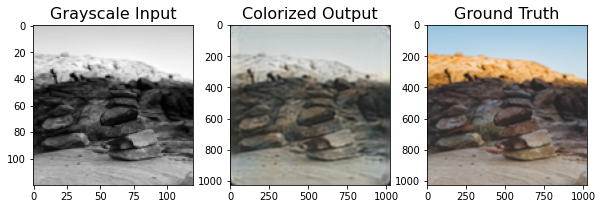

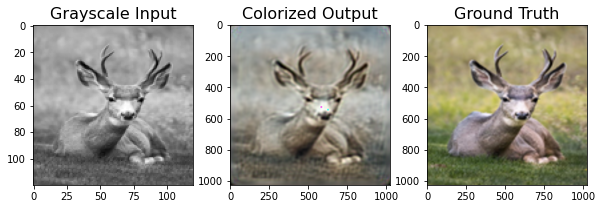

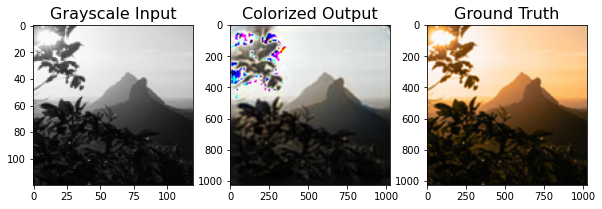

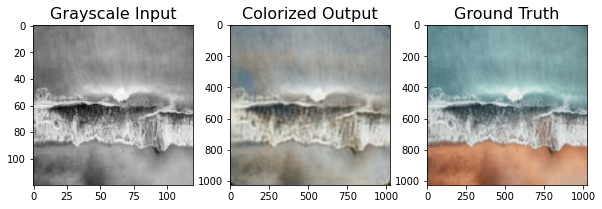

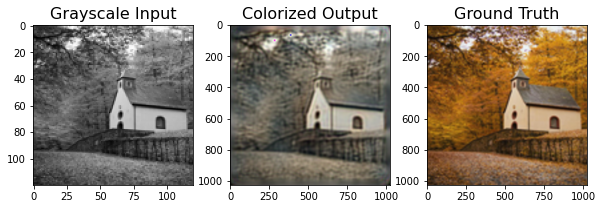

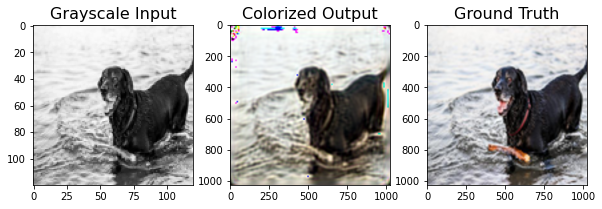

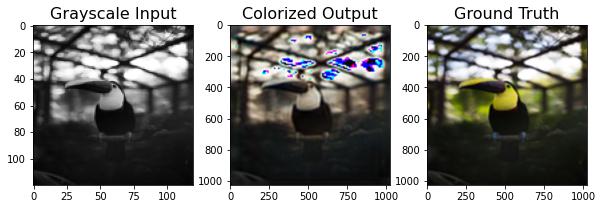

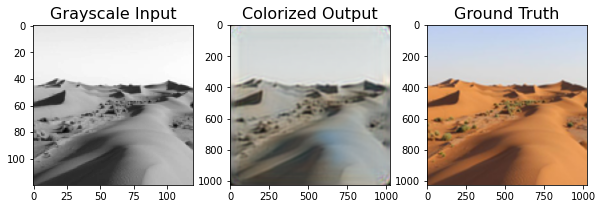

In [ ]:
for i in range(34, 86, 7):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_X[i].reshape((120,120)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()

### **Conclusion: We have successfully created our GAN and trained our Generator and Discriminator models to effectively generate colorized images from grayscale Images.**

### **The Model requires more training to make the images more closer to ground truth**